<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Alpha_RNNs_regime_switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive')

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf   
tf.disable_v2_behavior()
# Imports for stats


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from alphaRNN import *

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, eps=0.01):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    step_length=np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      mu[i*step_length:((i*step_length)+1)]=step_size*(-1)**i
     
    for i in range(1, length):
        sigma[i]=sigma[i-1] + mu[i] + eps*np.random.normal(0,1)
        
    return sigma   


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
p = 30 # the number of lags (in both the data and the models)
vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

In [0]:
df = pd.DataFrame(vols, columns=['vol'])

In [8]:
use_features = ['vol'] 
target = 'vol'
n_steps = 10 # number of lags to include in the model

train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df[use_features].iloc[:split]
print(df_train)
df_test = df[use_features].iloc[split:]

           vol
0     0.231808
1     0.233998
2     0.236245
3     0.238159
4     0.240415
...        ...
1571  0.149812
1572  0.153027
1573  0.156356
1574  0.159454
1575  0.163265

[1576 rows x 1 columns]


In [0]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [0]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(1566, 10, 1) (1566, 1, 1) (384, 10, 1) (384, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

In [0]:
print(train_batch_size)

1566


In [0]:
tf.get_collection('alpha_t')

[<tf.Tensor 'h_t_transposed/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_2/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_3/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_4/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_5/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_6/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_7/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_8/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_9/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_10/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_11/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_12/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_13/while/Sigmoid:0' shape=(?, 10) dtype=float64

In [0]:
#session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
#W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
#b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
#output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) 
#model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

#for model in models:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
#y_predicted_ar =np.array([0]*y_predicted_t.shape[0], dtype='float64')
#for i in range(y_predicted_t.shape[0]):
  #y_predicted_ar[i]=y_predicted[i][n_steps-1][0]
  #MSE_test += mean_squared_error(y_test[:,0],y_predicted_ar[i])

#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_train_reg})
#y_predicted_ar_train =np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
  #y_predicted_ar_train[i]=y_predicted[i][n_steps-1][0]
  #MSE_train += mean_squared_error(y_train[:,0],y_predicted_ar_train[i])
  
  #MSE_train_alpha = MSE_train/n_splits
  #print("MSE train alpha = " + str(MSE_train_alpha))
  #MSE_test_alpha = MSE_test/n_splits
  #print("MSE test alpha = " + str(MSE_test_alpha))
  #MSE_train_alpha_std = np.math.sqrt(MSE_train_alpha/(n_splits-1))
  #MSE_test_alpha_std = np.math.sqrt(MSE_test_alpha/(n_splits-1))
  #print("MSE_train_alpha_std = " + str(MSE_train_alpha_std))
  #print("MSE_test_alpha_std = " + str(MSE_test_alpha_std))

This is the main workflow=>



Epoch  0 / 2000 :  	Training Loss: 0.26942 	Validation Loss: 0.16198
Epoch  50 / 2000 :  	Training Loss: 0.08376 	Validation Loss: 0.08817
Epoch  100 / 2000 :  	Training Loss: 0.05330 	Validation Loss: 0.05980
Epoch  150 / 2000 :  	Training Loss: 0.04814 	Validation Loss: 0.05782
Epoch  200 / 2000 :  	Training Loss: 0.04345 	Validation Loss: 0.05326
Epoch  250 / 2000 :  	Training Loss: 0.03830 	Validation Loss: 0.04788
Epoch  300 / 2000 :  	Training Loss: 0.03182 	Validation Loss: 0.04100
Epoch  350 / 2000 :  	Training Loss: 0.02414 	Validation Loss: 0.03276
Epoch  400 / 2000 :  	Training Loss: 0.01842 	Validation Loss: 0.02666
Epoch  450 / 2000 :  	Training Loss: 0.01534 	Validation Loss: 0.02344
Epoch  500 / 2000 :  	Training Loss: 0.01369 	Validation Loss: 0.02175
Epoch  550 / 2000 :  	Training Loss: 0.01275 	Validation Loss: 0.02082
Epoch  600 / 2000 :  	Training Loss: 0.01220 	Validation Loss: 0.02028
Epoch  650 / 2000 :  	Training Loss: 0.01187 	Validation Loss: 0.01998
Epoch  70

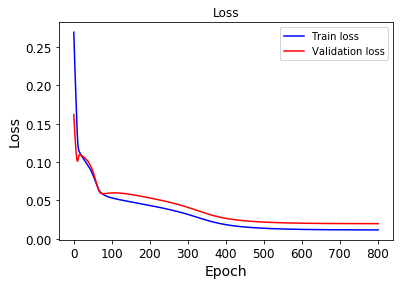

Epoch  0 / 2000 :  	Training Loss: 0.20590 	Validation Loss: 0.16600
Epoch  50 / 2000 :  	Training Loss: 0.03541 	Validation Loss: 0.03293
Epoch  100 / 2000 :  	Training Loss: 0.01869 	Validation Loss: 0.01720
Epoch  150 / 2000 :  	Training Loss: 0.01625 	Validation Loss: 0.01517
Epoch  200 / 2000 :  	Training Loss: 0.01550 	Validation Loss: 0.01457
Epoch  250 / 2000 :  	Training Loss: 0.01522 	Validation Loss: 0.01437
Epoch  300 / 2000 :  	Training Loss: 0.01512 	Validation Loss: 0.01430
Early stopping


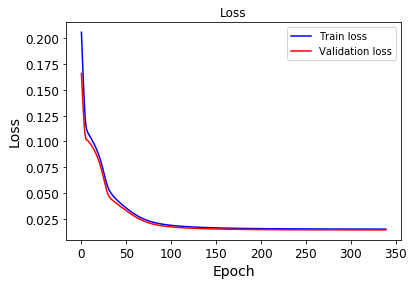

Epoch  0 / 2000 :  	Training Loss: 0.19144 	Validation Loss: 0.25391
Epoch  50 / 2000 :  	Training Loss: 0.01959 	Validation Loss: 0.01795
Epoch  100 / 2000 :  	Training Loss: 0.01542 	Validation Loss: 0.01279
Epoch  150 / 2000 :  	Training Loss: 0.01491 	Validation Loss: 0.01209
Epoch  200 / 2000 :  	Training Loss: 0.01485 	Validation Loss: 0.01201
Early stopping


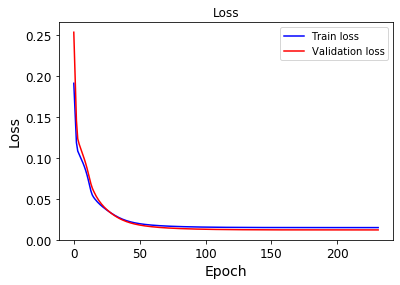

Epoch  0 / 2000 :  	Training Loss: 0.16815 	Validation Loss: 0.15528
Epoch  50 / 2000 :  	Training Loss: 0.01529 	Validation Loss: 0.01983
Epoch  100 / 2000 :  	Training Loss: 0.01418 	Validation Loss: 0.01892
Early stopping


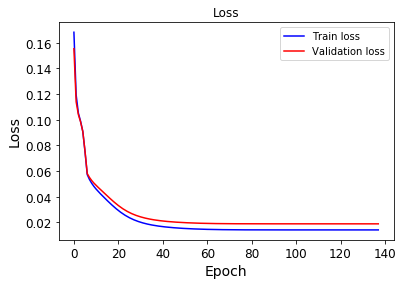

Epoch  0 / 2000 :  	Training Loss: 0.14420 	Validation Loss: 0.11646
Epoch  50 / 2000 :  	Training Loss: 0.01574 	Validation Loss: 0.01397
Epoch  100 / 2000 :  	Training Loss: 0.01514 	Validation Loss: 0.01334
Early stopping


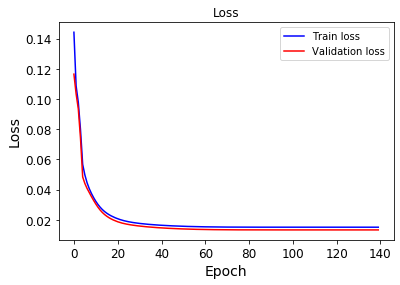

In [25]:
models = []
MSE_train = 0 
MSE_test = 0
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses=[]

for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn_t = simpleAlphaRNN(input_dimensions, hidden_sizes[i])
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss=train(session, alpharnn_t, x_train, x_test, y_train, y_test, max_epochs=2000, batch_size=int(100/n_splits))
  val_losses.append(val_loss)
  models.append(model)
  i+=1

Pick the model with the lowest val loss. you can *not* use the test set for model selection! This would be cheating


> Indented block



In [26]:
#Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses))
print(hidden_sizes[idx])

5


### Train on all training data with best model and predict on test set

Epoch  0 / 2000 :  	Training Loss: 0.22121 	Validation Loss: 0.22860
Epoch  50 / 2000 :  	Training Loss: 0.02242 	Validation Loss: 0.02172
Epoch  100 / 2000 :  	Training Loss: 0.01538 	Validation Loss: 0.01414
Epoch  150 / 2000 :  	Training Loss: 0.01482 	Validation Loss: 0.01348
Epoch  200 / 2000 :  	Training Loss: 0.01480 	Validation Loss: 0.01345
Early stopping


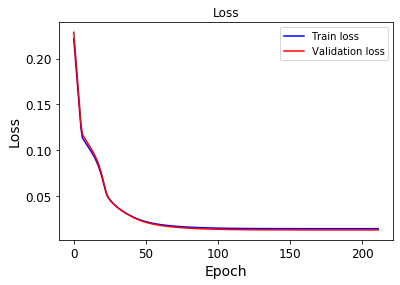

In [28]:
session = tf.Session()
alpharnn = simpleAlphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

In [0]:
y_predicted_t = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]

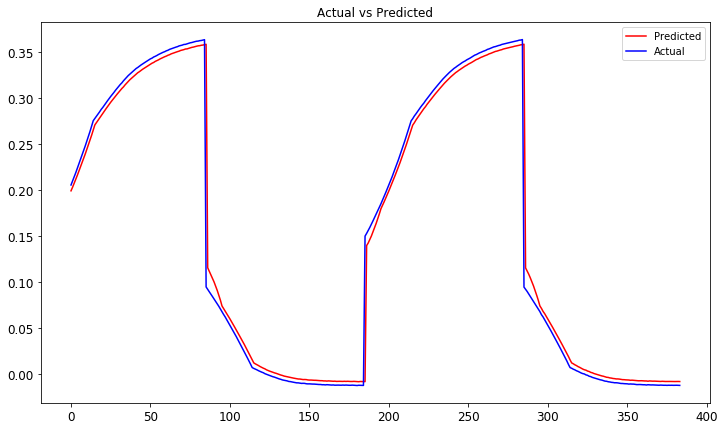

In [30]:
fig = plt.figure(figsize=(12,7))
plt.plot(y_predicted_ar_t, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted')
plt.show()

#Comparison with Keras models


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001)

In [0]:
def RNN_model2(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def GRU_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(GRU(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def LSTM_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    #LPNorm.build_loss(p = float('inf'))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

In [0]:
n_units = [10, 20, 30, 40, 50, 60, 100]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 10)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for RNN...")
model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=1)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]

Hyper parameter tuning for RNN...


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/2000
1566/1566 [==============================] - 13s 8ms/step - loss: 0.0413
Epoch 2/2000
1566/1566 [==============================] - 0s 28us/step - loss: 0.0229
Epoch 3/2000
1566/1566 [==============================] - 0s 27us/step - loss: 0.0027
Epoch 4/2000
1566/1566 [==============================] - 0s 29us/step - loss: 0.0011
Epoch 5/2000
1566/1566 [==============================] - 0s 28us/step - loss: 9.1861e-04
Epoch 6/2000
 100/1566 [>.............................] - ETA: 0s - loss: 1.6546e-04

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1566/1566 [==============================] - 0s 31us/step - loss: 8.6794e-04
Epoch 7/2000
1566/1566 [==============================] - 0s 29us/step - loss: 8.2146e-04
Epoch 8/2000
1566/1566 [==============================] - 0s 32us/step - loss: 7.8715e-04
Epoch 9/2000
1566/1566 [==============================] - 0s 33us/step - loss: 7.5906e-04
Epoch 10/2000
1566/1566 [==============================] - 0s 32us/step - loss: 7.1665e-04
Epoch 11/2000
1566/1566 [==============================] - 0s 31us/step - loss: 6.9844e-04
Epoch 12/2000
1566/1566 [==============================] - 0s 28us/step - loss: 6.6641e-04
Epoch 13/2000
1566/1566 [==============================] - 0s 28us/step - loss: 6.5739e-04
Epoch 14/2000
1566/1566 [==============================] - 0s 32us/step - loss: 6.4485e-04
Epoch 15/2000
1566/1566 [==============================] - 0s 30us/step - loss: 6.3995e-04
Epoch 16/2000
1566/1566 [==============================] - 0s 31us/step - loss: 6.0124e-04
Epoch 17/2000
15

In [0]:
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
n_splits = 10
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
MSE_train = 0
MSE_test = 0
TimeSeriesSplit(max_train_size=None, n_splits=10)
tscv = TimeSeriesSplit()
for train_fold, test_fold in tscv.split(x_train_reg):
    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
    rnn_model = RNN_model2(nodes,l1_reg)
   
    rnn_fit = rnn_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
    rnn_pred_train = rnn_model.predict(x_train, verbose=0)
    rnn_pred_test = rnn_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
    MSE_train += mean_squared_error(y_train[:,0], rnn_pred_train[:,0])
    MSE_test += mean_squared_error(y_test[:,0], rnn_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
rnn_model.summary()
MSE_train_ave = MSE_train/n_splits
MSE_train_std = np.math.sqrt(MSE_train/(n_splits-1))
MSE_test_ave = MSE_test/n_splits
MSE_test_std = np.math.sqrt(MSE_test/(n_splits-1))
print("MSE_train_rnn_ave = " + str(MSE_train_ave))
print("MSE_test_rnn_ave = " + str(MSE_test_ave))
print("MSE_train_rnn_std = " + str(MSE_train_std))
print("MSE_test_rnn_std = " + str(MSE_test_std))
print("p = " + str(p))

rnn_model = RNN_model2(nodes,l1_reg)
rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()




Epoch 1/2000
261/261 [==============================] - 1s 5ms/step - loss: 0.0433
Epoch 2/2000
261/261 [==============================] - 0s 58us/step - loss: 0.0287
Epoch 3/2000
261/261 [==============================] - 0s 51us/step - loss: 0.0152
Epoch 4/2000
261/261 [==============================] - 0s 65us/step - loss: 0.0048
Epoch 5/2000
261/261 [==============================] - 0s 63us/step - loss: 0.0043
Epoch 6/2000
261/261 [==============================] - 0s 65us/step - loss: 0.0042
Epoch 7/2000
261/261 [==============================] - 0s 68us/step - loss: 0.0012
Epoch 8/2000
261/261 [==============================] - 0s 61us/step - loss: 0.0027
Epoch 9/2000
261/261 [==============================] - 0s 59us/step - loss: 0.0019
Epoch 10/2000
261/261 [==============================] - 0s 66us/step - loss: 9.2133e-04
Epoch 11/2000
261/261 [==============================] - 0s 55us/step - loss: 0.0012
Epoch 12/2000
261/261 [==============================] - 0s 57us/step -

ValueError: ignored

In [0]:
print("Cross Validating LSTM with optmized parameters....")
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
MSE_train = 0
MSE_test = 0 
for train_fold, test_fold in tscv.split(x_train_reg):
    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
    lstm_model = LSTM_model2(nodes,l1_reg)
   
    lstm_fit = lstm_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
    lstm_pred_train = lstm_model.predict(x_train, verbose=0)
    lstm_pred_test = lstm_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
    MSE_train += mean_squared_error(y_train[:,0], lstm_pred_train[:,0])
    MSE_test += mean_squared_error(y_test[:,0], lstm_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
lstm_model.summary()
MSE_train_lstm_ave = MSE_train/n_splits
MSE_test_lstm_ave = MSE_test/n_splits
MSE_train_lstm_std = np.math.sqrt(MSE_train/(n_splits-1))
MSE_test_lstm_std = np.math.sqrt(MSE_test/(n_splits-1))
print("MSE_train_lstm_ave = " + str(MSE_train_lstm_ave))
print("MSE_test_lstm_ave = " + str(MSE_test_lstm_ave))
print("MSE_train_lmst_std = " + str(MSE_train_lstm_std))
print("MSE_test_lmst_std = " + str(MSE_test_lstm_std))

#print("neurons = " + str(n_steps))
#print("p = " + str(p))
#print("neurons = " + str(n_steps))
#print("l1 reg = 0")
# measure performane of test data using hyperparameters of best model
lstm_model = LSTM_model2(nodes,l1_reg)
lstm_fit = lstm_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()


Cross Validating LSTM with optmized parameters....
Epoch 1/2000
261/261 [==============================] - 3s 12ms/step - loss: 0.0605
Epoch 2/2000
261/261 [==============================] - 0s 166us/step - loss: 0.0559
Epoch 3/2000
261/261 [==============================] - 0s 165us/step - loss: 0.0512
Epoch 4/2000
261/261 [==============================] - 0s 167us/step - loss: 0.0460
Epoch 5/2000
261/261 [==============================] - 0s 167us/step - loss: 0.0407
Epoch 6/2000
261/261 [==============================] - 0s 166us/step - loss: 0.0345
Epoch 7/2000
261/261 [==============================] - 0s 163us/step - loss: 0.0271
Epoch 8/2000
261/261 [==============================] - 0s 173us/step - loss: 0.0182
Epoch 9/2000
261/261 [==============================] - 0s 213us/step - loss: 0.0103
Epoch 10/2000
261/261 [==============================] - 0s 177us/step - loss: 0.0056
Epoch 11/2000
261/261 [==============================] - 0s 180us/step - loss: 0.0064
Epoch 12/2000

ValueError: ignored

In [0]:
print("Cross Validating GRU with optmized parameters....")
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
MSE_train = 0
MSE_test = 0 
for train_fold, test_fold in tscv.split(x_train_reg):
    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
    gru_model = GRU_model2(nodes,l1_reg)
   
    gru_fit = gru_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
    gru_pred_train = gru_model.predict(x_train, verbose=0)
    gru_pred_test = gru_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
    MSE_train += mean_squared_error(y_train[:,0], gru_pred_train[:,0])
    MSE_test += mean_squared_error(y_test[:,0], gru_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
gru_model.summary()
MSE_train_gru_ave = MSE_train/n_splits
MSE_test_gru_ave = MSE_test/n_splits
MSE_train_gru_std = np.math.sqrt(MSE_train/(n_splits-1))
MSE_test_gru_std = np.math.sqrt(MSE_test/(n_splits-1))
print("MSE_train_gru_ave = " + str(MSE_train_gru_ave))
print("MSE_test_gru_ave = " + str(MSE_test_gru_ave))
print("MSE_train_gru_std = " + str(MSE_train_gru_std))
print("MSE_test_gru_std = " + str(MSE_test_gru_std))

print("p = " + str(p))  
     
gru_model = GRU_model2(nodes,l1_reg)
gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()


Cross Validating GRU with optmized parameters....
Epoch 1/2000
261/261 [==============================] - 3s 12ms/step - loss: 0.0607
Epoch 2/2000
261/261 [==============================] - 0s 114us/step - loss: 0.0545
Epoch 3/2000
261/261 [==============================] - 0s 121us/step - loss: 0.0488
Epoch 4/2000
261/261 [==============================] - 0s 112us/step - loss: 0.0439
Epoch 5/2000
261/261 [==============================] - 0s 124us/step - loss: 0.0392
Epoch 6/2000
261/261 [==============================] - 0s 139us/step - loss: 0.0345
Epoch 7/2000
261/261 [==============================] - 0s 117us/step - loss: 0.0301
Epoch 8/2000
261/261 [==============================] - 0s 121us/step - loss: 0.0252
Epoch 9/2000
261/261 [==============================] - 0s 122us/step - loss: 0.0202
Epoch 10/2000
261/261 [==============================] - 0s 119us/step - loss: 0.0151
Epoch 11/2000
261/261 [==============================] - 0s 122us/step - loss: 0.0101
Epoch 12/2000


In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 74us/step


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 47us/step


In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:],lstm_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], validation_losses[:, 0])
print(MSE_test)

ValueError: ignored

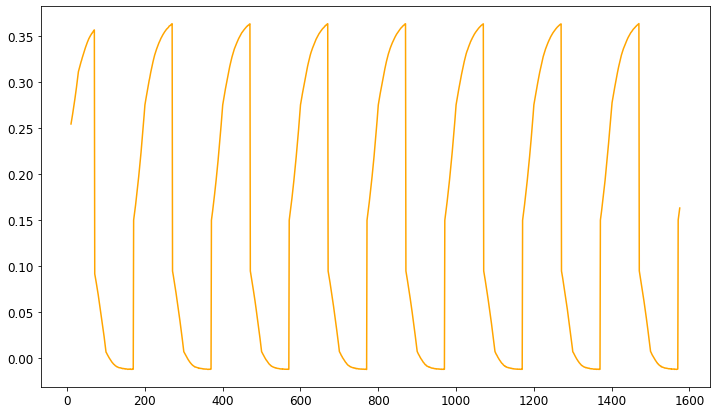

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="orange", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="black", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_train, color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_trian_t, color="yellow", label="alpha_t RNN Predict (Training)" )

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="orange", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="red", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="black", label="GRU Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], y_predicted_ar,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test,index[n_steps:], y_predicted_ar_t, color="yellow", label= "alpha_t RNN Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()